# Setup

In [1]:
# Core
import datetime
import os
import glob
import tempfile
import sys
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
%load_ext line_profiler

# Radar Tools
import pyart
import tint
import tint.visualization
import tint.visualization_aux
from tint import animate


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/563/esh563/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/563/esh563/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
import CPOL_func as cf
import caine_func as caf
import helpers

In [3]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualization
%aimport tint.visualization_aux
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport helpers

# Create Tracks

In [29]:
mp='reality'

In [6]:
def test():
    filenames = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2003-01-12 10:00'), 
                  np.datetime64('2003-01-12 16:00'), 
                  np.timedelta64(10, 'm'))
    )[0]
    
#     [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-09 00:00'), 
#                   np.datetime64('2006-02-13 12:30'), 
#                   np.timedelta64(10, 'm')), mp=mp
#     )

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = ['reflectivity', 'radar_estimated_rain_rate'])
             for fn in filenames)

    with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/circ_b_ind_set.pkl', 
              'rb') as f:
        b_ind_set = pickle.load(f)

    # Define settings for tracking
    settings = {
        'MIN_SIZE' : [40, 400, 800], # square km
        'FIELD_THRESH' : ['convective', 20, 15], # DbZ
        'ISO_THRESH' : [10, 10, 10], # DbZ
        'GS_ALT' : 3000,
        'SEARCH_MARGIN' : 50000, # m. This is just for object matching step:
        # does not affect flow vectors. Note CPOL cells 2500mx2500m. 
        'FLOW_MARGIN' : 40000, # m. Margin around object over which to
        # perform phase correlation.
        'LEVELS' : np.array( # m
            [[3000, 3500], 
             [3500, 7500],
             [7500, 10000]]
        ),
        'TRACK_INTERVAL' : 0,
        'BOUNDARY_GRID_CELLS' : b_ind_set,
        'UPDRAFT_START': 3000
    }

    tracks_obj  = tint.Cell_tracks()

    for parameter in ['MIN_SIZE', 'FIELD_THRESH', 'GS_ALT', 'LEVELS', 
                      'TRACK_INTERVAL', 'ISO_THRESH', 'SEARCH_MARGIN',
                      'FLOW_MARGIN', 'BOUNDARY_GRID_CELLS', 'UPDRAFT_START'
                     ]:
        tracks_obj.params[parameter] = settings[parameter]

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")
        
    # Calculate tracks
#     %lprun -T lprof0 -f tint.tracks.Cell_tracks.get_tracks tracks_obj.get_tracks(grids)
    tracks_obj.get_tracks(grids, rain=True, dt=dt)
    #tracks_obj = cf.get_reanalysis_vars(tracks_obj)
 
    out_file_name = ('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/'
                     + 'tracks_obj_{}_{}.pkl'.format(mp,dt))

#     with open(out_file_name, 'wb') as f:
#         pickle.dump(tracks_obj, f)
        
    return tracks_obj
        
if __name__ == '__main__':
    try:
        tracks_obj = test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)
        
# print(open('lprof0', 'r').read())

Gathering files.
Calculating additional tracks properties.
Calculating system tracks.


Time elapsed: 0.2 minutes


# Load Tracks

In [4]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_com_2001_2014.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

# Create Animations

In [ ]:
def test():
    lon_min = 131.0 - 1.6
    lon_max = 131.0 + 1.6

    lat_max = -12.2 + 1.6
    lat_min = -12.2 - 1.6
    
    tracks_obj_temp = tracks_obj

#     filenames, start_time, end_time = caf.caine_files_from_TINT_obj(
#         tracks_obj_temp, '13', mp=mp
#     )
    
    [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2003-01-11 11:50'), 
                  np.datetime64('2003-01-11 17:00'), 
                  np.timedelta64(10, 'm'))
    )

#     [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-09 10:00'), 
#                   np.datetime64('2006-02-09 11:00'), 
#                   np.timedelta64(10, 'm')), mp='lin'
#     )
    
#     tracks_obj_temp.tracks = tracks_obj_temp.tracks[sub_cond]
#     tracks_obj_temp.system_tracks = tracks_obj_temp.system_tracks[sub_cond_sys]

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_anim'

    animate(tracks_obj_temp, grids, out_path,
            start_datetime = start_time,
            end_datetime = end_time,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2),
            tracers=False, keep_frames=False, dpi=100, alt_low=3000,
            alt_high=10000, scan_boundary=False, wrf_winds=False, 
            line_coords=False, mp=mp, rain=False)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

In [ ]:
def test():
    uid = '13'
    filenames, start_time, end_time = caf.caine_files_from_TINT_obj(
        tracks_obj, uid, mp=mp    
    )

    lon_min = 131.0 - 2.6
    lon_max = 131.0 + 2.6

    lat_max = -12.2 + 2.6
    lat_min = -12.2 - 2.6
    
#     [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2003-12-20 08:20'), 
#                   np.datetime64('2003-12-20 08:30'), 
#                   np.timedelta64(10, 'm'))
#     )

#     [filenames, start_time, end_time] = caf.caine_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-09 10:30'), 
#                   np.datetime64('2006-02-09 10:40'), 
#                   np.timedelta64(10, 'm')), mp=mp
#     )

    grids = (pyart.io.read_grid(fn) for fn in filenames)  
    # refresh grid generator

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")
    
    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_lagrangian'
    animate(tracks_obj, grids, out_path, style='updraft', uid=uid, 
            alt_low=3000, alt_high=10000, keep_frames=False, dpi=100,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2), 
            center_ud=False, wrf_winds=True, line_coords=True,
            average_along_line=True, quiver=False, mp=mp)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

# Create Categories

In [11]:
categories = helpers.create_categories(tracks_obj)

In [21]:
categories['par_align'].groupby(level='uid').sum()

uid
0        7.0
1       10.0
10       4.0
100      0.0
1000     3.0
        ... 
9995    15.0
9996    17.0
9997     4.0
9998    13.0
9999    20.0
Name: par_align, Length: 25948, dtype: float64

In [25]:
subset_logic = categories['not_border'] & categories['not_border_0'] & ~categories['large_area'] & ~categories['small_area'] & categories['linear'] & ~categories['stationary'] & categories['sig_vel_mag']
sub_cat = categories[subset_logic]

In [26]:
sub_cat['par_align'].groupby(level='uid').sum().sort_values(ascending=False)[:20]

uid
2700     20.0
1605     19.0
10240    18.0
12038    16.0
2001     15.0
7970     14.0
1561     14.0
6845     14.0
8089     13.0
22990    13.0
6738     13.0
12047    13.0
1552     12.0
2688     12.0
2993     12.0
3733     12.0
2657     12.0
1390     11.0
2103     11.0
3763     11.0
Name: par_align, dtype: float64

In [27]:
sub_cat.xs('2700', level='uid')

,,eastward_motion,forward_tilt,backward_tilt,left_tilt,right_tilt,sig_tilt_mag,sig_vel_mag,stationary,linear,small_area,large_area,not_border,not_border_0,perp_align,par_align
scan,time,,,,,,,,,,,,,,,
9809,2003-01-11 11:50:00,False,False,False,False,True,True,True,False,True,False,False,True,True,False,True
9812,2003-01-11 12:20:00,False,False,True,False,False,True,True,False,True,False,False,True,True,False,True
9813,2003-01-11 12:30:00,False,False,False,False,True,True,True,False,True,False,False,True,True,True,False
9814,2003-01-11 12:40:00,False,False,False,False,True,True,True,False,True,False,False,True,True,False,True
9815,2003-01-11 12:50:00,False,False,False,False,True,True,True,False,True,False,False,True,True,False,True
9816,2003-01-11 13:00:00,False,False,False,False,True,True,True,False,True,False,False,True,True,False,True
9817,2003-01-11 13:10:03,False,False,False,False,True,True,True,False,True,False,False,True,True,False,True
9823,2003-01-11 14:10:03,False,False,True,False,False,True,True,False,True,False,False,True,True,False,True
9824,2003-01-11 14:20:00,False,False,True,False,False,True,True,False,True,False,False,True,True,False,True


# Calculate Some Statistics

## PS, TS, LS Breakdown

In [34]:
subset_logic = sig_area & not_border & not_border_0 & sig_vel_mag & sig_tilt_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
# sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS, totals] = [np.zeros(100) for i in range(4)]

for i in sub_uids:
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']
    
    # Break down sig_tilt categories
    forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
    backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        TS[bwd_inds] += 1
        LS[fwd_inds] += 1
        PS[pll_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

## System Size

In [7]:
# subset_logic = ~small_area
# sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_tracks = tracks_obj.system_tracks

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [14]:
# Create 3 lists with lengths the lifetime of longest object.
[large, small, medium, nb, totals] = [np.zeros(100) for i in range(5)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
    
#     import pdb
#     pdb.set_trace()
    
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = categories.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    large_area = cat['large_area'].values
    small_area = cat['small_area'].values
    medium_area = ~large_area & ~small_area
    not_border = cat['not_border'].values | cat['not_border_0'].values
    
    large_inds = scan_label[large_area]
    medium_inds = scan_label[medium_area]
    small_inds = scan_label[small_area]
    not_border_inds = scan_label[not_border]
    totals_inds = scan_label.tolist()
    
    # Break down sig_tilt categories
#     forward_tilt = ((-45 <= tilts) & (tilts <= 45)) 
#     backward_tilt = ((-135 >= tilts) | (tilts >= 135)) 

#     fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
#     bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
#     pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        large[large_inds] += 1
        small[small_inds] += 1
        medium[medium_inds] += 1
        nb[not_border_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 25948/25948 [02:18<00:00, 186.83it/s]


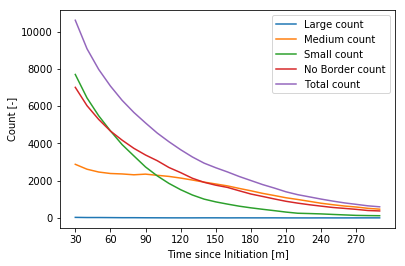

In [17]:
plt.plot(np.arange(30,300,10), large[3:30], label='Large count')
plt.plot(np.arange(30,300,10), medium[3:30], label='Medium count')
plt.plot(np.arange(30,300,10), small[3:30], label='Small count')
plt.plot(np.arange(30,300,10), nb[3:30], label='No Border count')
plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

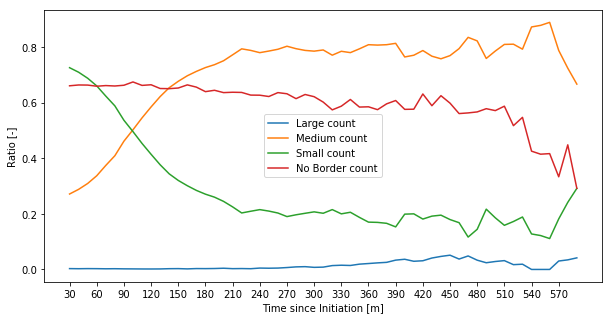

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(30,600,10), (large/totals)[3:60], label='Large count')
plt.plot(np.arange(30,600,10), (medium/totals)[3:60], label='Medium count')
plt.plot(np.arange(30,600,10), (small/totals)[3:60], label='Small count')
plt.plot(np.arange(30,600,10), (nb/totals)[3:60], label='No Border count')
plt.xticks(np.arange(30,600,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_ratios.png')

## Training Lines

In [12]:
subset_logic = categories['not_border'] & categories['not_border_0'] & ~categories['large_area'] & ~categories['small_area'] & categories['linear'] & ~categories['stationary'] & categories['sig_vel_mag']
sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_cat = categories[subset_logic]
# sub_tracks = tracks_obj.system_tracks
# sub_cat = categories

sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

# MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]
# max_MCS = max(MCS_lengths)

In [13]:
# Create 3 lists with lengths the lifetime of longest object.
[par, perp, totals] = [np.zeros(100) for i in range(3)]

from tqdm import tqdm

for i in tqdm(sub_uids, file=sys.stdout, position=0, leave=True):
       
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    cat = sub_cat.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    
    # Define classifications
    perp_align = cat['perp_align'].values
    par_align = cat['par_align'].values
        
    par_inds = scan_label[par_align]
    perp_inds = scan_label[perp_align]
    totals_inds = scan_label.tolist()

    # Found error with large com dataset - object 14060 jumps across seasons
    try:
        par[par_inds] += 1
        perp[perp_inds] += 1
        totals[totals_inds] += 1
    except:
        print('Error with system {}.'.format(i))

100%|██████████| 952/952 [00:04<00:00, 205.99it/s]


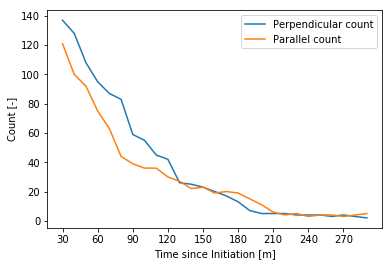

In [14]:
plt.plot(np.arange(30,300,10), perp[3:30], label='Perpendicular count')
plt.plot(np.arange(30,300,10), par[3:30], label='Parallel count')
# plt.plot(np.arange(30,300,10), totals[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

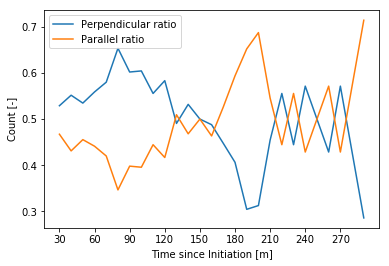

In [18]:
plt.plot(np.arange(30,300,10), (perp/totals)[3:30], label='Perpendicular ratio')
plt.plot(np.arange(30,300,10), (par/totals)[3:30], label='Parallel ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/size_counts.png')

## Updraft Tilt versus Stratiform Tilt

In [29]:
def calc_mean_max_updrafts(system_tracks, min_height_ind = 20):
    ud = system_tracks['updrafts']
    ud_tilt = []
    tallest_ud = []
    mean_ud = []
    no_tilt=0
    for i in range(len(ud)):
        ud_i = ud.iloc[i]
        ud_tilt_i = []
        for j in range(len(ud_i)):
            if ud_i[j][-1][0] >= min_height_ind:
                ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
                if np.all(ud_tilt_i_j[1:3] == [0,0]):
                    # Count updrafts with no tilt seperately
                    no_tilt+=1
                else:
                    ud_tilt_i.append(ud_tilt_i_j)
       
        if ud_tilt_i != []:
            ud_tilt.append(ud_tilt_i)
            mean_ud.append(np.nanmean(np.array(ud_tilt_i), axis=0))
        else:
            ud_tilt.append(np.ones(3)*np.nan)
            mean_ud.append(np.ones(3)*np.nan)
        try:
            tallest_ind = np.argmax(np.array(ud_tilt_i)[:,0])
            tallest_ud.append(np.array(ud_tilt_i)[tallest_ind,:])
        except:
            tallest_ud.append(np.ones(3)*np.nan)
        
    return ud_tilt, mean_ud, tallest_ud

### Tallest Updraft

In [33]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(tallest_ud)
den = np.tile(np.array(tallest_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

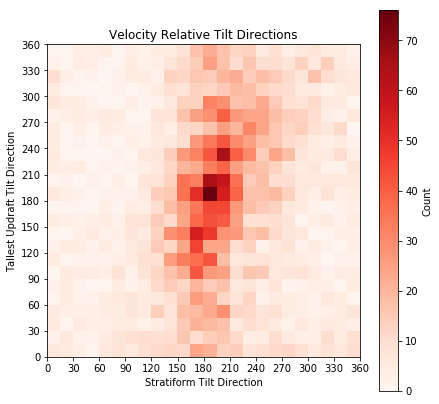

In [35]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Tallest Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')

### Mean Updraft

In [36]:
subset_logic = sig_area & not_border & sig_tilt_mag & not_border_0 & sig_vel_mag
sub_tracks = tracks_obj.system_tracks[subset_logic]
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(sub_tracks)

num = np.array(mean_ud)
den = np.tile(np.array(mean_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

vel_dir = sub_tracks['vel_dir'].values
tilt_dir = sub_tracks['tilt_dir'].values

sys_rel_tilt_dir = np.mod(tilt_dir - vel_dir, 360)
sys_rel_tilt_dir = np.round(sys_rel_tilt_dir, 3)

sys_rel_ud_tilt_dir = np.mod(ud_dir - vel_dir, 360)
sys_rel_ud_tilt_dir = np.round(sys_rel_ud_tilt_dir, 3)

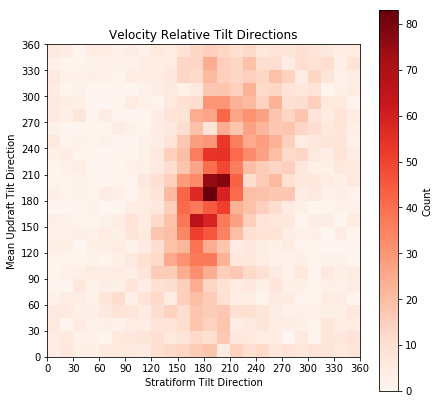

In [38]:
vel_dir = sub_tracks['vel_dir'].values
vel_mag = np.sqrt(sub_tracks['u_shift']**2 + sub_tracks['v_shift']**2).values
tilt_dir = sub_tracks['tilt_dir'].values
bins = np.arange(0,360+15,15)
ticks = np.arange(0,360+30,30)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
h = ax.hist2d(sys_rel_tilt_dir, sys_rel_ud_tilt_dir, bins=bins, range=[[0, 360], [0, 360]], cmap='Reds')
# ax.scatter(tilt_dir, ud_dir, s=0.75)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Mean Updraft Tilt Direction')
plt.title('Velocity Relative Tilt Directions')
plt.xlim([0, 360])
plt.ylim([0, 360])
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_aspect('equal')
cb = plt.colorbar(h[3], ax=ax)
cb.set_label('Count')